# 📰 Fake News Detection with RoBERTa, Emotion/Sentiment Analysis, and XAI
**Includes:** Preprocessing, Fine-Tuning, Visualization, Emotion/Sentiment Features, and LIME Explanations

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from transformers import pipeline
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
train_df = pd.read_csv('train.tsv', sep='\t')
val_df = pd.read_csv('validation.tsv', sep='\t')

print("training set nulls: ")
print(train_df.isnull().sum())
train_df.dropna(inplace=True)

print()

print("validation set nulls: ")
print(val_df.isnull().sum())
val_df.dropna(inplace=True)

training set nulls: 
Unnamed: 0    0
title         0
text          0
subject       0
date          0
label         0
dtype: int64

validation set nulls: 
Unnamed: 0    0
title         0
text          0
subject       0
date          0
label         0
dtype: int64


In [2]:
train_df['title'] = train_df['title'].astype(str).str.strip()
train_df['subject'] = train_df['subject'].astype(str).str.strip()
train_df['text'] = train_df['text'].astype(str).str.strip()

train_df['content'] = train_df['title'] + ' ' + train_df['subject'] + ' ' + train_df['text']

train_df.head(5)

,Unnamed: 0,title,text,subject,date,label,content
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1,Ex-CIA head says Trump remarks on Russia inter...
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1,Federal Reserve governor Powell's policy views...
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0,NANCY PELOSI ARROGANTLY DISMISSES Questions on...


In [3]:
val_df['title'] = val_df['title'].astype(str).str.strip()
val_df['subject'] = val_df['subject'].astype(str).str.strip()
val_df['text'] = val_df['text'].astype(str).str.strip()

val_df['content'] = val_df['title'] + ' ' + val_df['subject'] + ' ' + val_df['text']

val_df.head(5)

,Unnamed: 0,title,text,subject,date,label,content
0,14074,TRUMP HATER GEORGE RAMOS Promotes Movie Showin...,Mexico has been the beneficiary of our open bo...,politics,"Apr 20, 2016",0,TRUMP HATER GEORGE RAMOS Promotes Movie Showin...
1,17592,Germany seeks to maintain unity if U.S. decert...,The German government on Friday vowed to work ...,worldnews,"October 13, 2017",1,Germany seeks to maintain unity if U.S. decert...
2,5694,No sign U.S. wants to cancel nuclear deal with...,German Foreign Minister Sigmar Gabriel said it...,politicsNews,"February 2, 2017",1,No sign U.S. wants to cancel nuclear deal with...
3,20036,Brazil prosecutors seek to extend Batista dete...,The Office of Brazil s Prosecutor-General Rodr...,worldnews,"September 14, 2017",1,Brazil prosecutors seek to extend Batista dete...
4,234,Trump Just Asked The Most Unqualified Person E...,"Trump, who keeps promising to either scrap our...",News,"October 10, 2017",0,Trump Just Asked The Most Unqualified Person E...


In [ ]:
def clean_for_bert(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.encode('ascii', 'ignore').decode()
    text = text.lower()
    
    return text.strip()

In [5]:
train_df['content'] = train_df['content'].apply(clean_for_bert)
val_df['content'] = val_df['content'].apply(clean_for_bert)

print("Cleaned training set content:")
print(train_df['content'].head(5))
print()
print("Cleaned validation set content:")
print(val_df['content'].head(5))

Cleaned training set content:
0    ex-cia head says trump remarks on russia inter...
1    you wont believe his punishment! hispanic stor...
2    federal reserve governor powell's policy views...
3    scoundrel hillary supporter starts trumpleaks ...
4    nancy pelosi arrogantly dismisses questions on...
Name: content, dtype: object

Cleaned validation set content:
0    trump hater george ramos promotes movie showin...
1    germany seeks to maintain unity if u.s. decert...
2    no sign u.s. wants to cancel nuclear deal with...
3    brazil prosecutors seek to extend batista dete...
4    trump just asked the most unqualified person e...
Name: content, dtype: object


In [ ]:
def plot_class_distribution(df, label_col='label', title='Class Distribution'):

    # Count and percentage
    class_counts = df[label_col].value_counts()
    class_percent = df[label_col].value_counts(normalize=True) * 100

    # Map numeric to string labels
    label_names = {0: 'FAKE', 1: 'REAL'}
    labels_str = class_counts.index.map(label_names)

    # Create display DataFrame
    class_df = pd.DataFrame({
        'label': labels_str,
        'count': class_counts.values,
        'percent': class_percent.values
    })

    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(data=class_df, x='label', y='count', hue='label', palette='Set2', legend=False)

    for i, row in class_df.iterrows():
        plt.text(i, row['count'] + class_df['count'].max() * 0.01, 
                 f"{int(row['count'])} ({row['percent']:.2f}%)", 
                 ha='center', fontsize=12)

    plt.title(title, fontsize=14)
    plt.ylabel("Number of Samples")
    plt.xlabel("Class")
    plt.tight_layout()
    plt.show()


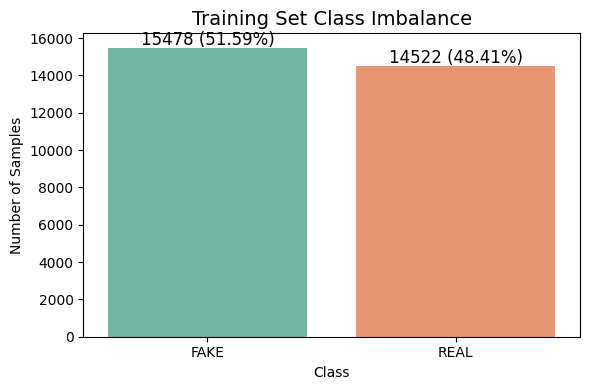

In [7]:
plot_class_distribution(train_df, label_col='label', title='Training Set Class Imbalance')

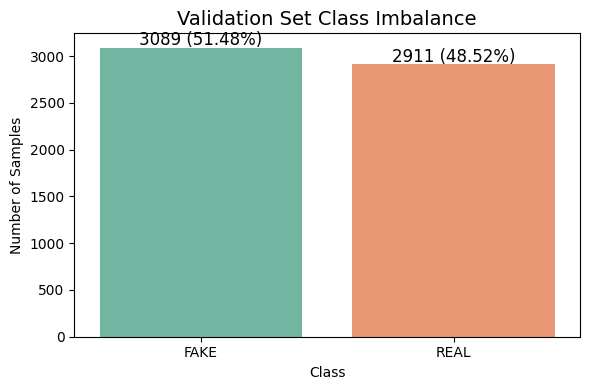

In [8]:
plot_class_distribution(val_df, label_col='label', title='Validation Set Class Imbalance')

In [9]:
train_ds = train_df[['content', 'label']]
train_ds.head()

,content,label
0,ex-cia head says trump remarks on russia inter...,1
1,you wont believe his punishment! hispanic stor...,0
2,federal reserve governor powell's policy views...,1
3,scoundrel hillary supporter starts trumpleaks ...,0
4,nancy pelosi arrogantly dismisses questions on...,0


In [10]:
val_ds = val_df[['content', 'label']]
val_ds.head()

,content,label
0,trump hater george ramos promotes movie showin...,0
1,germany seeks to maintain unity if u.s. decert...,1
2,no sign u.s. wants to cancel nuclear deal with...,1
3,brazil prosecutors seek to extend batista dete...,1
4,trump just asked the most unqualified person e...,0


In [12]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

In [13]:
def tokenize_texts_with_tokenizer(texts, tokenizer):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors='pt'
    )

In [14]:
train_x = list(train_ds['content'])
train_y = list(train_ds['label'])
val_x = list(val_ds['content'])
val_y = list(val_ds['label'])

In [15]:
train_encodings = tokenize_texts_with_tokenizer(train_x, tokenizer)
val_encodings = tokenize_texts_with_tokenizer(val_x, tokenizer)

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [17]:
train_dataset = NewsDataset(train_encodings, train_y)
val_dataset = NewsDataset(val_encodings, val_y)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [19]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    'distilroberta-base', num_labels=2
).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [23]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

train_accuracies = []
val_accuracies = []

for epoch in range(3):
    model.train()
    train_loss = 0
    true_labels_train = []
    preds_train = []

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training"):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        train_loss += loss.item()

        # For training accuracy
        predictions = torch.argmax(logits, dim=-1)
        preds_train.extend(predictions.cpu().numpy())
        true_labels_train.extend(labels.cpu().numpy())

    train_acc = accuracy_score(true_labels_train, preds_train)
    train_accuracies.append(train_acc)

    print(f"\nEpoch {epoch + 1} | Train loss: {train_loss / len(train_loader):.4f} | Train Accuracy: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    preds_val, true_labels_val = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch["labels"]

            outputs = model(**batch)
            logits = outputs.logits
            loss = outputs.loss

            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            preds_val.extend(predictions.cpu().numpy())
            true_labels_val.extend(labels.cpu().numpy())

    val_acc = accuracy_score(true_labels_val, preds_val)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch + 1} | Val loss: {val_loss / len(val_loader):.4f} | Validation Accuracy: {val_acc:.4f}")


Epoch 1 - Training: 100%|██████████| 3750/3750 [2:20:04<00:00,  2.24s/it]  



Epoch 1 | Train loss: 0.0011 | Train Accuracy: 0.9998
Epoch 1 | Val loss: 0.0000 | Validation Accuracy: 1.0000


Epoch 2 - Training: 100%|██████████| 3750/3750 [59:06<00:00,  1.06it/s]



Epoch 2 | Train loss: 0.0008 | Train Accuracy: 0.9999
Epoch 2 | Val loss: 0.0018 | Validation Accuracy: 0.9998


Epoch 3 - Training: 100%|██████████| 3750/3750 [1:09:29<00:00,  1.11s/it]  



Epoch 3 | Train loss: 0.0000 | Train Accuracy: 1.0000
Epoch 3 | Val loss: 0.0018 | Validation Accuracy: 0.9998


In [24]:
model.save_pretrained("saved_model/")
tokenizer.save_pretrained("saved_model/")

('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.json',
 'saved_model/merges.txt',
 'saved_model/added_tokens.json',
 'saved_model/tokenizer.json')

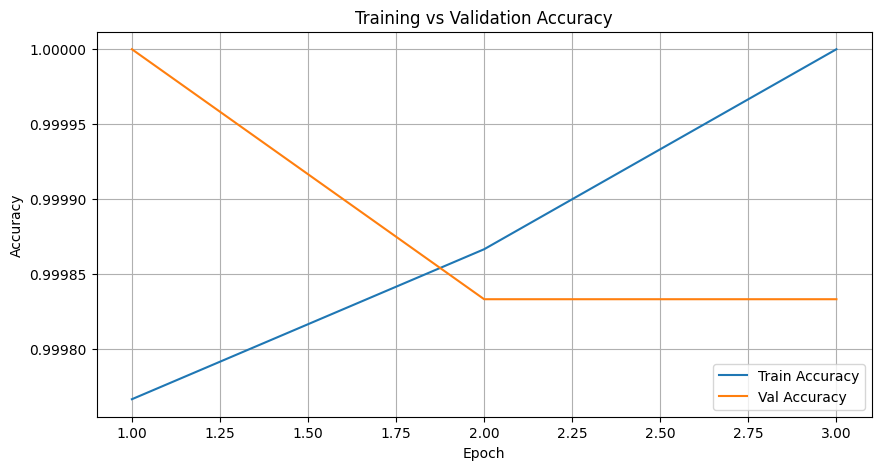

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, 4), y=train_accuracies, label="Train Accuracy")
sns.lineplot(x=range(1, 4), y=val_accuracies, label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Device set to use cuda:0
Device set to use cuda:0


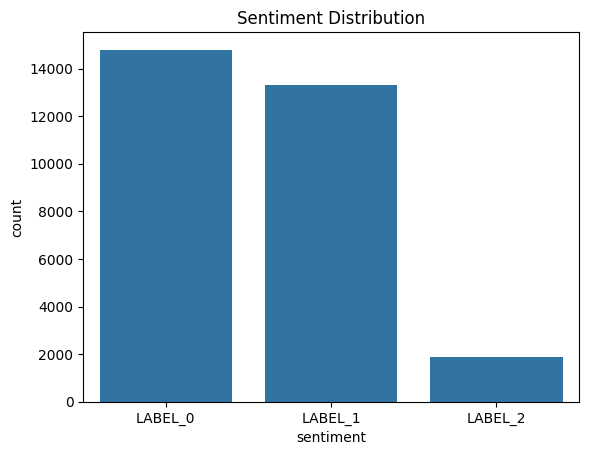

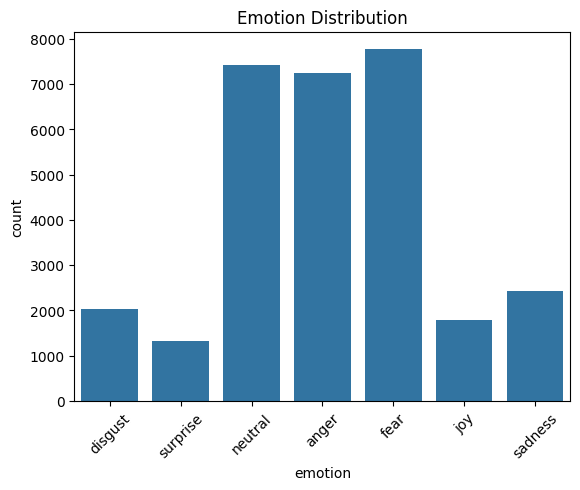

In [ ]:
# Sentiment and Emotion Analysis

# Load pipelines
sentiment_analyzer = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment')
emotion_analyzer = pipeline('text-classification', model='j-hartmann/emotion-english-distilroberta-base', top_k=1)

# Define helper functions
def get_sentiment(text):
    try:
        return sentiment_analyzer(text[:512])[0]['label']
    except Exception as e:
        return 'unknown'

def get_emotion(text):
    try:
        return emotion_analyzer(text[:512])[0][0]['label']
    except Exception as e:
        return 'unknown'

# Apply analysis
train_df['sentiment'] = train_df['text'].apply(get_sentiment)
train_df['emotion'] = train_df['text'].apply(get_emotion)

# Plot Sentiment Distribution
sns.countplot(data=train_df, x='sentiment')
plt.title('Sentiment Distribution')
plt.show()

# Plot Emotion Distribution
sns.countplot(data=train_df, x='emotion')
plt.title('Emotion Distribution')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from lime.lime_text import LimeTextExplainer
import numpy as np

class_names = ['FAKE', 'REAL']
explainer = LimeTextExplainer(class_names=class_names)

def predict_proba(texts, batch_size=32):
    all_probs = []

    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            encodings = tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors='pt'
            )
            encodings = {k: v.to(device) for k, v in encodings.items()}
            logits = model(**encodings).logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            all_probs.append(probs.cpu().numpy())

    return np.concatenate(all_probs, axis=0)

In [ ]:
text = train_df.iloc[10]['content']
exp = explainer.explain_instance(text, predict_proba, num_features=10)

for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

politicsnews: 0.9977
may: 0.0002
trumps: 0.0002
miller: 0.0002
to: 0.0002
website: 0.0002
transition: 0.0002
supports: 0.0001
u: 0.0001
forward: 0.0001
